In [1]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(input):
    return 1./(1.+np.exp(-input))

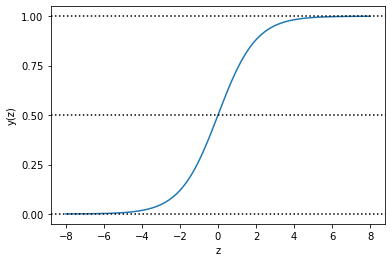

In [2]:
z = np.linspace(-8,8,1000)
y = sigmoid(z)

plt.plot(z,y)
plt.axhline(y=0,ls='dotted',color='k')
plt.axhline(y=0.5,ls='dotted',color='k')
plt.axhline(y=1,ls='dotted',color='k')

plt.yticks([0.0,0.25,.5,.75,1.])
plt.xlabel('z')
plt.ylabel('y(z)')
plt.show()

### Get & Preprocess Data

In [4]:
import pandas as pd
data = pd.read_csv('./ctr_data_20000.csv')

In [5]:
data.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [6]:
data = data.drop(['id','hour','device_id','device_ip'],axis = 1)

In [9]:
from sklearn.feature_extraction import DictVectorizer
data_x = data.loc[:,data.columns != 'click'].astype('str')
data_y = data.loc[:,data.columns == 'click'].astype('int').values.ravel()

train_X, test_X = data_x[0:15000],data_x[15000:]
train_y, test_y = data_y[0:15000],data_y[15000:]

dict_one_hot_encoder = DictVectorizer(sparse=False)
onehot_train_X = dict_one_hot_encoder.fit_transform(train_X.to_dict('records'))
one_hot_test_X = dict_one_hot_encoder.transform(test_X.to_dict('records'))

In [10]:
print(train_X.shape)
print(onehot_train_X.shape)

(15000, 19)
(15000, 3244)


In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(fit_intercept=True, max_iter=10000)
logistic_regression.fit(onehot_train_X,train_y)

pos_prob = logistic_regression.predict_proba(one_hot_test_X)[:,1]
print("ROC AUC: {0:.3f}".format(roc_auc_score(test_y,pos_prob)))

ROC AUC: 0.710


# Stochastic Gradient Descent

In [13]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
parameters = {'eta0':[0.1,0.01,0.001]}

sgd_lr = SGDClassifier(loss = 'log',fit_intercept=True)
grid_search = GridSearchCV(sgd_lr,parameters,n_jobs=-1,cv=3,scoring='roc_auc')

grid_search.fit(onehot_train_X,train_y)
sgd_lr_best = grid_search.best_estimator_
pos_prob  = sgd_lr_best.predict_proba(one_hot_test_X)[:,1]

print("ROC AUC: {0:.3f}".format(roc_auc_score(test_y,pos_prob)))

ROC AUC: 0.710


# Regularization

L1

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
parameters = {'eta0':[0.1,0.01,0.001]}

sgd_lr = SGDClassifier(loss = 'log',fit_intercept=True, penalty='l1')
grid_search = GridSearchCV(sgd_lr,parameters,n_jobs=-1,cv=3,scoring='roc_auc')

grid_search.fit(onehot_train_X,train_y)
sgd_lr_best = grid_search.best_estimator_
pos_prob  = sgd_lr_best.predict_proba(one_hot_test_X)[:,1]

print("ROC AUC: {0:.3f}".format(roc_auc_score(test_y,pos_prob)))

ROC AUC: 0.712


L2

In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
parameters = {'eta0':[0.1,0.01,0.001]}

sgd_lr = SGDClassifier(loss = 'log',fit_intercept=True, penalty='l2')
grid_search = GridSearchCV(sgd_lr,parameters,n_jobs=-1,cv=3,scoring='roc_auc')

grid_search.fit(onehot_train_X,train_y)
sgd_lr_best = grid_search.best_estimator_
pos_prob  = sgd_lr_best.predict_proba(one_hot_test_X)[:,1]

print("ROC AUC: {0:.3f}".format(roc_auc_score(test_y,pos_prob)))

ROC AUC: 0.705


elasticnet

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
parameters = {'eta0':[0.1,0.01,0.001]}

sgd_lr = SGDClassifier(loss = 'log',fit_intercept=True, penalty='elasticnet')
grid_search = GridSearchCV(sgd_lr,parameters,n_jobs=-1,cv=3,scoring='roc_auc')

grid_search.fit(onehot_train_X,train_y)
sgd_lr_best = grid_search.best_estimator_
pos_prob  = sgd_lr_best.predict_proba(one_hot_test_X)[:,1]

print("ROC AUC: {0:.3f}".format(roc_auc_score(test_y,pos_prob)))

ROC AUC: 0.714


# Multi-class Classification

Get Data

In [19]:
import nltk
nltk.download('names')
nltk.download('wordnet')

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\KIST\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KIST\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer

all_names = set(names.words())
lemmatizer = WordNetLemmatizer()

In [23]:
def clean_text(docs):
    cleanned_docs = []
    for doc in docs:
        lemmatized_list = [lemmatizer.lemmatize(word.lower()) for word in doc.split() if word.isalpha() and word not in all_names]
        cleanned_docs.append(''.join(lemmatized_list))
    return cleanned_docs

In [24]:
from sklearn.datasets import fetch_20newsgroups

data_train = fetch_20newsgroups(subset='train',categories=None,random_state=42)
data_test = fetch_20newsgroups(subset='test',categories=None,random_state=42)

In [25]:
cleanned_train = clean_text(data_train.data)
label_train = data_train.target

cleanned_test = clean_text(data_test.data)
label_test= data_test.target

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=.5, stop_words='english',max_features=40000)
term_docs_train = tfidf_vectorizer.fit_transform(cleanned_train)
term_docs_test = tfidf_vectorizer.transform(cleanned_test)

In [32]:
parameters = {'penalty':['l2',None],
             'alpha':[1e-07,1e-06,1e-05,1e-04],
             'eta0':[0.01,0.1,1,10]}

sgd_lr = SGDClassifier(loss ='log',learning_rate='constant',eta0 = 0.01,fit_intercept=True)

grid_search = GridSearchCV(sgd_lr,parameters,n_jobs=-1,cv=3)
grid_search.fit(term_docs_train,label_train)
print(grid_search.best_params_)

{'alpha': 1e-07, 'eta0': 0.01, 'penalty': 'l2'}


In [33]:
sgd_lr_best = grid_search.best_estimator_
accuracy = sgd_lr_best.score(term_docs_test,label_test)
print('The accuracy on test set is:{0:.1f}%'.format(accuracy*100))

The accuracy on test set is:5.4%


정확도 너무 낮아서,, 가져옴

src: https://github.com/PacktPublishing/Python-Machine-Learning-By-Example/blob/master/Chapter06/5scikit_logistic_regression.py

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import SGDClassifier
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer

all_names = set(names.words())
lemmatizer = WordNetLemmatizer()

def letters_only(astr):
    for c in astr:
        if not c.isalpha():
            return False
    return True

def clean_text(docs):
    cleaned_docs = []
    for doc in docs:
        cleaned_docs.append(' '.join([lemmatizer.lemmatize(word.lower())
                                        for word in doc.split()
                                        if letters_only(word)
                                        and word not in all_names]))
    return cleaned_docs

data_train = fetch_20newsgroups(subset='train', categories=None, random_state=42)
data_test = fetch_20newsgroups(subset='test', categories=None, random_state=42)

cleaned_train = clean_text(data_train.data)
label_train = data_train.target
cleaned_test = clean_text(data_test.data)
label_test = data_test.target

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english', max_features=40000)
term_docs_train = tfidf_vectorizer.fit_transform(cleaned_train)
term_docs_test = tfidf_vectorizer.transform(cleaned_test)

In [37]:
# combined with grid search
from sklearn.model_selection import GridSearchCV
parameters = {'penalty': ['l2', None],
              'alpha': [1e-07, 1e-06, 1e-05, 1e-04],
              'eta0': [0.01, 0.1, 1, 10]}

sgd_lr = SGDClassifier(loss='log', learning_rate='constant', eta0=0.01, fit_intercept=True)

grid_search = GridSearchCV(sgd_lr, parameters, n_jobs=-1, cv=3)

grid_search.fit(term_docs_train, label_train)
print(grid_search.best_params_)

sgd_lr_best = grid_search.best_estimator_
accuracy = sgd_lr_best.score(term_docs_test, label_test)
print('The accuracy on testing set is: {0:.1f}%'.format(accuracy*100))

{'alpha': 1e-06, 'eta0': 10, 'penalty': 'l2'}
The accuracy on testing set is: 79.9%
